In [1]:
import pandas as pd
import pyodbc as db
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
conrds = db.connect(driver = '{ODBC Driver 13 for SQL Server}',
                    server = 'gather-cpt-team-7.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com,1433',
                    database = 'water_crisis_proc',
                    user = 'gather_cpt_team_7',
                    password = '83632593293')

In [27]:
rain_data = pd.read_sql('select * from RecordedRainfall', conrds)

dam_levels = pd.read_sql('select * from DamLevels', conrds)

rain_stations = pd.read_sql('select * from RainStations', conrds)

supply_dams = pd.read_sql('select * from SupplyDams', conrds)

In [29]:
rain_df = pd.merge(rain_data, rain_stations, how = 'inner', on ='rain_station_id')
rain_df = rain_df[['date','precipitation', 'name']]

In [38]:
storage_df = pd.merge(dam_levels, supply_dams, how = 'inner', on = 'supply_dam_id')
storage_df = storage_df[['date',  'name','height', 'storage', 'total_dam_capacity', 'categories']]

In [39]:
storage_df.head()

,date,name,height,storage,total_dam_capacity,categories
0,2012-01-01,WEMMERSHOEK,48.2,44621.0,58634,Major Dam
1,2012-01-02,WEMMERSHOEK,48.2,44571.0,58634,Major Dam
2,2012-01-03,WEMMERSHOEK,48.2,44471.0,58634,Major Dam
3,2012-01-04,WEMMERSHOEK,48.1,44372.0,58634,Major Dam
4,2012-01-05,WEMMERSHOEK,48.1,44322.0,58634,Major Dam


In [40]:
storage_df = storage_df[storage_df['storage'].notna()].copy()

In [41]:
def dates(df):
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

In [42]:
dates(storage_df)
dates(rain_df)

In [43]:
storage_df.head()

,date,name,height,storage,total_dam_capacity,categories,month,year
0,2012-01-01,WEMMERSHOEK,48.2,44621.0,58634,Major Dam,1,2012
1,2012-01-02,WEMMERSHOEK,48.2,44571.0,58634,Major Dam,1,2012
2,2012-01-03,WEMMERSHOEK,48.2,44471.0,58634,Major Dam,1,2012
3,2012-01-04,WEMMERSHOEK,48.1,44372.0,58634,Major Dam,1,2012
4,2012-01-05,WEMMERSHOEK,48.1,44322.0,58634,Major Dam,1,2012


In [44]:
def merging(df_x, df_y, group, column_x, column_y, shift = 0):
    
    x = df_x.groupby(group)[[column_x]].mean().shift()
    y = df_y.groupby(group)[[column_y]].mean().diff()
    merge = pd.merge(x,y,how = 'inner', on = group)
    return merge

In [45]:
merged = merging(rain_df, storage_df, 'month', 'precipitation', 'storage',1)

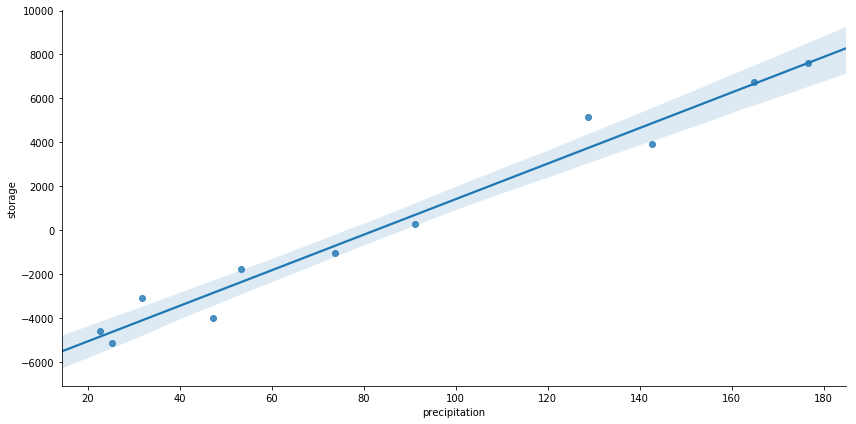

In [46]:
sns.lmplot(x = 'precipitation', y = 'storage', data = merged, height = 6, aspect = 2)
plt.savefig('fig.png')

In [47]:
merged.head()

,precipitation,storage
month,,
1,NaN,NaN
2,25.229240,-5113.185530
3,22.651332,-4572.367466
4,31.671961,-3090.406593
5,73.819399,-1050.499823


In [48]:
def subplots_db(df, column_1,label_1, column_2, label_2,  title_):    
    fig, ax = plt.subplots(figsize = [24,8])
    plt.plot(df[column_1], label = label_1)
    plt.legend(loc=2)
    ax.tick_params('vals')

    plt.gca().set_title(title_)

    ax2 = ax.twinx()
    plt.plot(df[column_2], 'orange', label = label_2)
    plt.legend(loc=1)
    ax.tick_params('vals')
    plt.savefig('water_storage_rain.png')

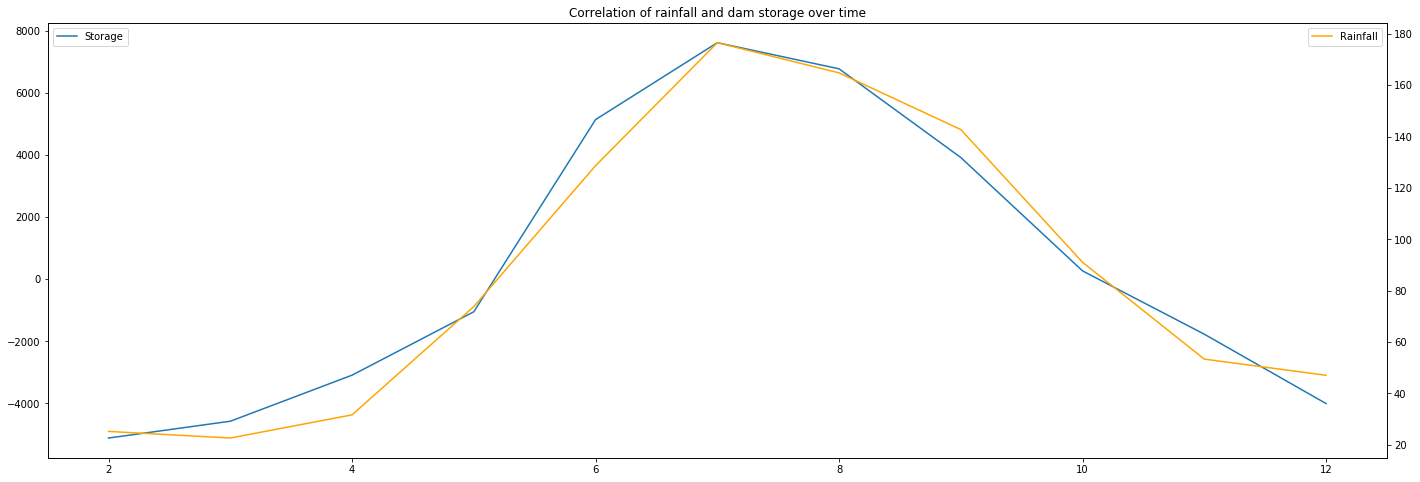

In [49]:
subplots_db(merged,'storage', 'Storage', 'precipitation', 'Rainfall', 'Correlation of rainfall and dam storage over time')